In [1]:
import cv2
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

# Resize images

In [2]:
IMG_PATH = Path('../VOCdevkit/VOC2007/JPEGImages')
NEW_PATH = Path('../VOCdevkit/VOC2007/JPEGImages_300_300')

In [ ]:
str(list(IMG_PATH.iterdir())[0]).split('/')[-1]

In [ ]:
def resize_img_and_write(size=300):
    for path in tqdm(list(IMG_PATH.iterdir())):
        img = cv2.imread(str(path))
        x_resized = cv2.resize(img, (size, size))
        fname = str(path).split('/')[-1]
        cv2.imwrite(str(NEW_PATH/fname), x_resized)

In [ ]:
resize_img_and_write()

# Resize bboxes

In [4]:
def make_bb_px(y, x_shape):
    """Makes an image of size x rectangular bounding box (hw format)"""
    Y = np.zeros(x_shape)
    y = hw_bb_numpy(y).astype(np.int)
    y = np.array(list(map(lambda x: x if x > 0 else 0, y)))  # clip to 0
    Y[y[0]:y[2], y[1]:y[3]] = 1.
    return Y


def to_bb(Y):
    """
    Convert mask Y to a corner format bounding box
    Assumes 0 as background nonzero object
    """
    cols, rows = np.nonzero(Y)
    if len(cols) == 0:
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row],
                    dtype=np.float32)


def hw_bb_numpy(bb):
    if len(bb.shape) == 1:
        return np.array([bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1])
    else:
        return np.array([bb[..., 1],
                         bb[..., 0],
                         bb[..., 3] + bb[..., 1] - 1,
                         bb[..., 2] + bb[..., 0] - 1])
    

def bb_hw_numpy(bb: np.array) -> np.array:
    """Transform from corner format to width-height format.
    (Numpy version)

    width-height: [X, Y, width, height]
    corner format: [Y_0, X_0, Y_right_bottom, X_right_bottom]
    """
    if len(bb.shape) == 1:
        return np.array([bb[1], bb[0], bb[3] - bb[1] + 1, bb[2] - bb[0] + 1])
    else:
        return np.array([bb[..., 1],
                         bb[..., 0],
                         bb[..., 3] - bb[..., 1] + 1,
                         bb[..., 2] - bb[..., 0] + 1], dtype=np.float32)

In [5]:
PATH = Path('/data/xhan/Dropbox/resized_512/')
train_bbox_df = pd.read_csv('../data/train_anno.csv')
val_bbox_df = pd.read_csv('../data/val_anno.csv')

In [6]:
# resize bounding boxes accordingly
def resize_bbox(orig_shape, bbox, target_size):
    """Resize bounding boxes accordingly.

    :param orig_shape: shape of original image
    :param bbox: bounding boxes
    :param target_size: size of the resized image
    :return: new boxes (corner format)
    """
    Y = make_bb_px(bbox, orig_shape)
    y_resize = cv2.resize(Y, target_size)
    y = to_bb(y_resize)
    y[0], y[2] = (np.clip(y[0], 0, target_size[0]),
                  np.clip(y[2], 0, target_size[0]))
    y[1], y[3] = (np.clip(y[1], 0, target_size[1]),
                  np.clip(y[3], 0, target_size[1]))
    return y

In [7]:
def resize_annotation_bbox(df, target_size):
    """Generate new annotation data frame with resized image path
    and new bounding boxes' coordinates.

    :param df: annotation data frame
    """
    target_size = int(target_size)
    y_new = []
    for i, bbox in enumerate(df['bbox']):
        path = df['fn_orig'][i]
        # the original microfiber images has different sizes
        img = cv2.imread(str(path))
        r, c, _ = img.shape  # original img size
        y = np.array([int(b) for b in bbox.split()])
        if len(y) == 4:
            new_bb = resize_bbox((r, c), y, (target_size, target_size))
            y_new.append(' '.join([str(int(n)) for n in new_bb]))
        elif len(y) > 4:
            temp_bbs = []
            for j in range(int(len(y) / 4)):
                resized_bb = resize_bbox((r, c), y[j * 4:(j * 4 + 4)],
                                         (target_size, target_size))
                resized_bb = ' '.join([str(int(n)) for n in resized_bb])
                temp_bbs.append(resized_bb)
            y_new.append(' '.join(temp_bbs))

    df['bbox_300'] = y_new
    return y_new

In [8]:
y_new = resize_annotation_bbox(train_bbox_df, 512)

In [9]:
train_bbox_df.head(10)

,fn_orig,fn_new,label,bbox,bbox_300
0,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/resized_512/23213.jpeg,1 1,69 668 150 71 604 1108 71 68,199 32 219 103 330 286 349 319
1,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/resized_512/18543.jpeg,1,921 747 52 44,222 436 234 460
2,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/resized_512/17841.jpeg,1,737 391 111 179,116 349 169 401
3,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/resized_512/28499.jpeg,1,785 1206 50 39,359 372 369 395
4,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/resized_512/8079.jpeg,1,558 29 134 56,8 264 24 327
5,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/resized_512/18129.jpeg,1,248 585 46 58,174 117 190 138
6,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/resized_512/31581.jpeg,1 1,385 1508 69 35 944 1333 39 41,449 182 458 214 397 447 408 465
7,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/resized_512/14003.jpeg,1,244 439 48 96,131 115 158 137
8,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/resized_512/28024.jpeg,1,806 1491 106 38,444 382 454 431
9,/data/xhan/Dropbox/USF MantaRay Data Share/Ima...,/data/xhan/Dropbox/resized_512/14182.jpeg,1,171 362 66 52,108 81 122 111


In [ ]:
train_bbox_df.to_csv(PATH/'tmp/train_bbox_multi.csv', index=False)
val_bbox_df.to_csv(PATH/'tmp/val_bbox_multi.csv', index=False)

In [10]:
def bounding_box(bb):
    """switch x/y coords to be consistent with numpy, convert height/width into top-left/bottom-right"""
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

# open image
def load_image(img_path):
    img = cv2.imread(str(img_path)).astype(np.float32)/255
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    return ax


def draw_outline(plt_object, lw):
    plt_object.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])


def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(
        b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)


def draw_text(ax, xy, txt, font_sz=14):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color='white', fontsize=font_sz, weight='bold')
    draw_outline(text, 1)

In [11]:
category = {0: 'background', 1: 'microfiber'}

/data/xhan/Dropbox/resized_512/3262.jpeg
Bounding box:
X: 489
Y: 221
Width: 13
Height: 53
microfiber


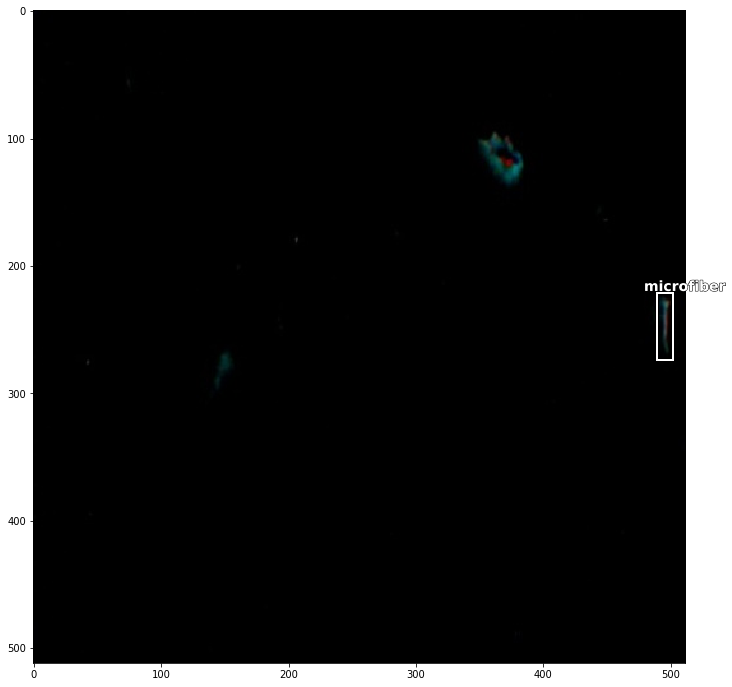

In [20]:
idx = np.random.randint(0, len(train_bbox_df), 1)
sample = train_bbox_df.iloc[idx, :]

img_path = '/'+'/'.join(sample['fn_new'].values[0].split('/')[1:])
print(img_path)
boxes = [int(c) for c in sample['bbox_300'].values[0].split()]
img = load_image(img_path)
labels = [int(lab) for lab in sample['label'].values[0].split()]
ax = show_img(img, figsize=(12, 12))

for i in range(int(len(boxes)/4)):
    b = bb_hw_numpy(np.array(boxes[i*4:(i*4+4)]))
    print(f'Bounding box:\nX: {b[0]}\nY: {b[1]}\nWidth: {b[2]}\nHeight: {b[3]}')
    draw_rect(ax, b)
    text = category[labels[i]]
    print(text)
    draw_text(ax, b[:2]-10, text)